In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='spike hz'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=-1):
        """Pad or truncate signal to the target length with various strategies."""
        signal = np.array(signal)
        current_length = len(signal)
        
        if current_length >= target_length:
            return signal[:target_length]

        padding_size = target_length - current_length

        if mode == "constant":
            return np.pad(signal, (0, padding_size), 'constant', constant_values=constant_value)
        elif mode == "reflect":
            return np.pad(signal, (0, padding_size), 'reflect')
        elif mode == "cyclic":
            return np.pad(signal, (0, padding_size), 'wrap')
        elif mode == "edge":
            return np.pad(signal, (0, padding_size), 'edge')
        elif mode == "random":
            random_padding = np.random.uniform(low=np.min(signal), high=np.max(signal), size=padding_size)
            return np.concatenate((signal, random_padding))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        _, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd

In [26]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment # 是否启用数据增强
        
        self.num_good = num_good
        self.num_bad = num_bad

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_name='spike hz')  # Load EEG signal
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + len(signal) * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < 16 * 3600 or start_time > 68 * 3600:
                    print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly

        return torch.tensor(augmented_signal, dtype=torch.float32).unsqueeze(0), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = len(signal)  # Total length of the EEG recording
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (16 * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        current_length = len(signal)
        if current_length >= target_length:
            return signal[:target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full(padding_size, constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, (0, padding_size), mode='reflect')[-padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, (0, padding_size), mode='wrap')[-padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, (0, padding_size), mode='edge')[-padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=padding_size)
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # **Pad at the beginning or end**
        if padding_position == "pre":
            padded_signal = np.concatenate((pad_values, signal))  # **Pad at the beginning**
        else:
            padded_signal = np.concatenate((signal, pad_values))  # **Pad at the end**

        return padded_signal[:target_length]  # **Ensure the final length is exactly `target_length`**

    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        current_length = len(signal)  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if len(augmented_signal) < target_length:
            padding_size = target_length - len(augmented_signal)

            if shift > 0:
                # **Right shift: Pad at the beginning**
                augmented_signal = np.concatenate((self.pad_signal([], padding_size, self.padding_mode), augmented_signal))
            elif shift < 0:
                # **Left shift: Pad at the end**
                augmented_signal = np.concatenate((augmented_signal, self.pad_signal([], padding_size, self.padding_mode)))
            else:
                # **shift == 0, no padding needed**
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count

In [27]:
# AugmentedEEGDataset
class AugmentedEEGDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, eeg_dataset_instance, augment=True, num_good=10, num_bad=2):
        self.base_dataset = base_dataset
        self.eeg_dataset_instance = eeg_dataset_instance  # 保存实例
        self.augment = augment
        self.num_good = num_good
        self.num_bad = num_bad
        self.expanded_data = []

        for i in range(len(base_dataset)):
            signal, label = base_dataset[i]
            repeat = num_good if label == 1 else num_bad  # 按类别决定增强比例

            for _ in range(repeat):
                augmented_signal = self.eeg_dataset_instance.augment_signal(signal.numpy().squeeze()) if self.augment else signal.numpy().squeeze()
                self.expanded_data.append((augmented_signal, label))

    def __len__(self):
        return len(self.expanded_data)

    def __getitem__(self, idx):
        signal, label = self.expanded_data[idx]
        return torch.tensor(signal, dtype=torch.float32).unsqueeze(0), label
# 统计类别信息
def count_labels(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]  # 取出所有样本的 label
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

In [28]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [29]:
def train(model, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for data, label in dataloader:  # We don't use the labels during unsupervised training for VAE
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        reconstruction, mean, logvar = model(data)

        # Compute the reconstruction loss (mean squared error)
        recon_loss = criterion(reconstruction, data)

        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

        # Combine the losses
        loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # Accumulate the total loss for this batch

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss per sample
    return epoch_loss


def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data, label in dataloader:  
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data, label  in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

In [30]:
def extract_latent_features(vae_model, dataset):

    latent_features = []
    labels = []
    
    if hasattr(dataset, 'expanded_indices'):
        #print("🔹 Detected `AugmentedEEGDataset`, extracting features from expanded data...")
        dataset_type = "augmented"
    else:
        #print("🔹 Detected `EEGDataset` or `Subset`, extracting features normally...")
        dataset_type = "original"

    vae_model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            signal, label = dataset[i]

            if isinstance(signal, torch.Tensor):
                signal = signal.unsqueeze(0).to(device)  # 加入 batch 维度
            else:
                signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).to(device)  

            latent_vector = vae_model.get_embedding(signal).cpu().numpy()
            latent_features.append(latent_vector.flatten())
            labels.append(label)

    print(f"✅ Feature extraction complete! Extracted {len(latent_features)} samples.")
    return np.array(latent_features), np.array(labels)

import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_augmented_samples(dataset, num_samples=5):
    """
    Randomly selects num_samples augmented EEG samples and visualizes their waveforms 
    with the x-axis starting from 16 hours.

    Parameters:
    - dataset: An instance of EEGDataset
    - num_samples: Number of samples to visualize
    """
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # Randomly select an index
        sample, label = dataset[idx]  # Retrieve the augmented data
        sample = sample.squeeze(0).numpy()  # Remove the channel dimension
        
        # Compute the time axis in hours, ensuring the same length as sample
        start_time = 16  # Start at 16 hours
        time_axis = np.linspace(start_time, start_time + (len(sample) - 1) * 5 / 60, len(sample))

        # Plot the EEG signal
        axes[i].plot(time_axis, sample, label=f"Sample {i+1} (Label: {label})", color='b')
        axes[i].set_title(f"Sample {i+1} (Label: {label})")
        axes[i].set_xlabel("Time (hours)")
        axes[i].set_ylabel("Amplitude")
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def visualize_reconstruction(vae_model, dataset, num_samples=5):
    """
    Visualizes original EEG signals, their VAE reconstructions, and the latent space representations.
    
    Parameters:
    - vae_model: Trained VAE model
    - dataset: EEG dataset instance
    - num_samples: Number of samples to visualize
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae_model.eval()  # Set model to evaluation mode

    # 3 columns: original signal, reconstructed signal, latent vector
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 3 * num_samples))
    axes = np.atleast_2d(axes)  # Ensure axes is always 2D to avoid errors when num_samples=1

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  
        sample, _ = dataset[idx]  
        sample = sample.unsqueeze(0).to(device)  

        # VAE inference
        with torch.no_grad():
            reconstruction, mu, log_var = vae_model(sample)  # Extract latent variables
        
        sample = sample.squeeze().cpu().numpy()
        reconstruction = reconstruction.squeeze().cpu().numpy()
        mu = mu.squeeze().cpu().numpy()  # Extract latent vector

        print(f"Sample {i+1} shape: {sample.shape}, Reconstruction shape: {reconstruction.shape}")
        #print(f"Latent vector {i+1}: {mu}")

        start_time = 16  
        time_axis = np.linspace(start_time, start_time + (len(sample) - 1) * 5 / 60, len(sample))

        assert len(time_axis) == len(sample), "Time axis length mismatch!"

        # (1) Original Signal
        axes[i, 0].plot(time_axis, sample, color='b', alpha=0.7)
        axes[i, 0].set_title(f"Sample {i+1} - Original Signal")
        axes[i, 0].set_xlabel("Time (hours)")
        axes[i, 0].set_ylabel("Amplitude")
        axes[i, 0].grid(True)

        # (2) Reconstructed Signal
        axes[i, 1].plot(time_axis, reconstruction, color='r', linestyle='dashed', alpha=0.7)
        axes[i, 1].set_title(f"Sample {i+1} - Reconstructed Signal")
        axes[i, 1].set_xlabel("Time (hours)")
        axes[i, 1].set_ylabel("Amplitude")
        axes[i, 1].grid(True)

        # (3) Visualizing the Latent Space (Bar Plot)
        axes[i, 2].bar(range(len(mu)), mu, color='g', alpha=0.7)
        axes[i, 2].set_title(f"Sample {i+1} - Latent Space")
        axes[i, 2].set_xlabel("Latent Dimension Index")
        axes[i, 2].set_ylabel("Value")
        axes[i, 2].grid(True)

    plt.tight_layout()
    plt.savefig("vae_reconstruction_with_latent.png")  # Save for debugging
    plt.show()

❌ Skipping ICARE_0779: EEG data is out of 16h-68h range (5.9h - 10.4h)
❌ Skipping ICARE_0544: EEG data is out of 16h-68h range (4.3h - 14.3h)
❌ Skipping ICARE_0550: EEG data is out of 16h-68h range (15.3h - 15.6h)
❌ Skipping ICARE_0592: EEG data is out of 16h-68h range (5.5h - 6.6h)
❌ Skipping ICARE_0753: EEG data is out of 16h-68h range (8.2h - 13.5h)
❌ Skipping ICARE_0025: EEG data is out of 16h-68h range (4.8h - 10.6h)
❌ Skipping ICARE_0232: EEG data is out of 16h-68h range (12.4h - 13.7h)
❌ Skipping ICARE_0540: EEG data is out of 16h-68h range (3.5h - 12.9h)
❌ Skipping ICARE_0839: EEG data is out of 16h-68h range (5.8h - 10.9h)
❌ Skipping ICARE_0185: EEG data is out of 16h-68h range (8.2h - 13.4h)
❌ Skipping ICARE_0218: EEG data is out of 16h-68h range (10.8h - 11.8h)
❌ Skipping ICARE_0068: EEG data is out of 16h-68h range (3.1h - 4.9h)
❌ Skipping ICARE_0083: EEG data is out of 16h-68h range (9.2h - 11.7h)
❌ Skipping ICARE_0055: EEG data is out of 16h-68h range (8.6h - 8.7h)
❌ Skip

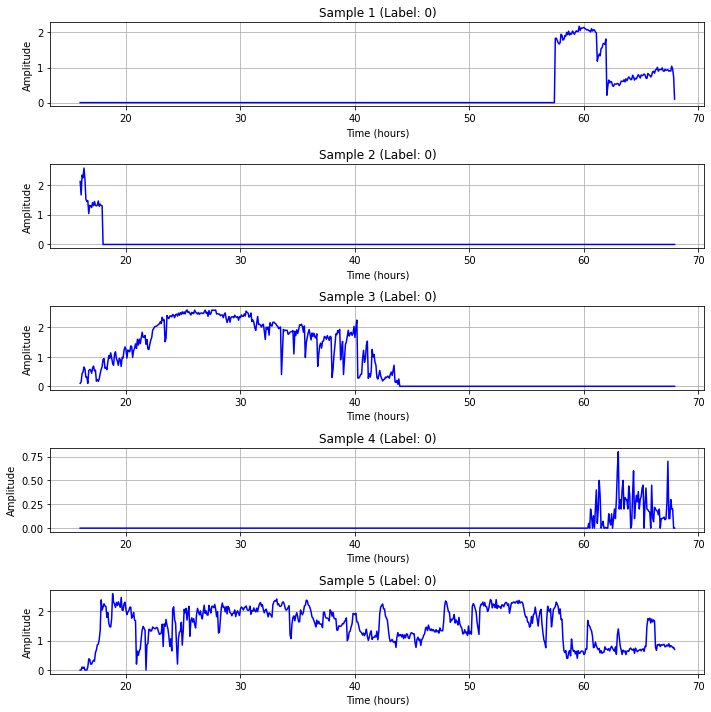

Train set size (before augmentation): 212
Train set label distribution: {0: 177, 1: 35}
Test set size: 54
Test set label distribution: {0: 46, 1: 8}


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter settings
latent_dim = 10  # Dimension of the latent space
initial_channels = 128  # Initial number of channels for CNN
seq_length = (68 - 16) * 12  # Number of `5min` windows for 52 hours (624)
batch_size = 32
epochs = 100
alpha = 1e-6  # Weight for KL loss
patience = 10  # Define the number of epochs without improvement before stopping training
padding_method = 'constant'  # Use constant padding
is_augment = True  # Enable data augmentation
num_good_train=5
num_bad_train=2
num_good_test=5
num_bad_test=2
is_VAEtrain_aug=False

# Define dataset folder paths
data_folder = '5min_smoothed_data/'  # Replace with the actual data folder path
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file = 'files_art_ssd_fts_predictions.csv'

# Create EEG dataset (labels are not used when training VAE)
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # Use labels to determine class-based augmentation
    augment=False,  # Enable data augmentation
)

visualize_augmented_samples(eeg_dataset, num_samples=5)  # Random Visualize 5 sapmle

seed_value = 3  
torch.manual_seed(seed_value)
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

print(f"Train set size (before augmentation): {len(train_dataset)}")
print(f"Train set label distribution: {count_labels(train_dataset)}")  
print(f"Test set size: {len(test_dataset)}")
print(f"Test set label distribution: {count_labels(test_dataset)}")  

# Augment the training set and the training set respectively
augmented_train_dataset = AugmentedEEGDataset(train_dataset, eeg_dataset, augment=is_augment, num_good=num_good_train, num_bad=num_bad_train)
augmented_test_dataset = AugmentedEEGDataset(test_dataset, eeg_dataset, augment=is_augment, num_good=num_good_test, num_bad=num_bad_test)

# Create DataLoader
if is_VAEtrain_aug:
    print("\n Augment the training set and the training set respectively:\n")
    aug_labels = [augmented_train_dataset[i][1] for i in range(len(augmented_train_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Train set size (after augmentation): {len(augmented_train_dataset)}")
    print(f"Train set label distribution (after augmentation): {dict(zip(unique, counts))}")



    aug_labels = [augmented_test_dataset[i][1] for i in range(len(augmented_test_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Test set size (after augmentation): {len(augmented_test_dataset)}")
    print(f"Test set label distribution (after augmentation): {dict(zip(unique, counts))}")

    train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(augmented_test_dataset, batch_size=batch_size, shuffle=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
augmented_test_loader = DataLoader(augmented_test_dataset, batch_size=batch_size, shuffle=False)


Epoch 1/100, Train Loss: 0.5555, Test Loss: 0.3781
Epoch 2/100, Train Loss: 0.2584, Test Loss: 0.3319
Epoch 3/100, Train Loss: 0.2584, Test Loss: 0.3195
Epoch 4/100, Train Loss: 0.2369, Test Loss: 0.2801
Epoch 5/100, Train Loss: 0.2096, Test Loss: 0.2542
Epoch 6/100, Train Loss: 0.1918, Test Loss: 0.2413
Epoch 7/100, Train Loss: 0.1754, Test Loss: 0.2354
Epoch 8/100, Train Loss: 0.1632, Test Loss: 0.2007
Epoch 9/100, Train Loss: 0.1464, Test Loss: 0.1735
Epoch 10/100, Train Loss: 0.1291, Test Loss: 0.1512
Epoch 11/100, Train Loss: 0.1162, Test Loss: 0.1332
Epoch 12/100, Train Loss: 0.1088, Test Loss: 0.1213
Epoch 13/100, Train Loss: 0.1033, Test Loss: 0.1160
Epoch 14/100, Train Loss: 0.0982, Test Loss: 0.1121
Epoch 15/100, Train Loss: 0.0934, Test Loss: 0.1041
Epoch 16/100, Train Loss: 0.0867, Test Loss: 0.0986
Epoch 17/100, Train Loss: 0.0834, Test Loss: 0.0933
Epoch 18/100, Train Loss: 0.0789, Test Loss: 0.0924
Epoch 19/100, Train Loss: 0.0771, Test Loss: 0.0870
Epoch 20/100, Train L

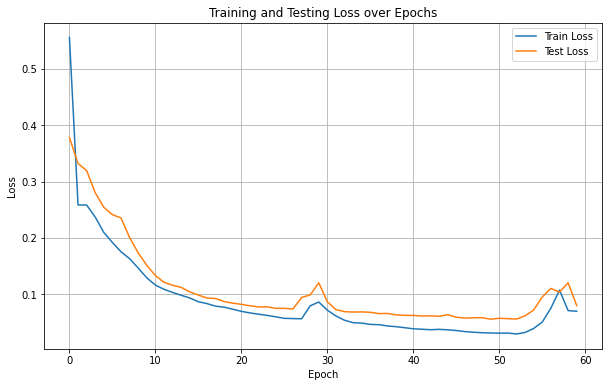

In [32]:
# Define model, loss function, and optimizer
vae_model = VAE(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

# Lists for training and testing losses (used for plotting)
train_losses = []
test_losses = []

# Early stopping variables
best_test_loss = float('inf')
epochs_no_improve = 0

# Training loop
for epoch in range(epochs):
    train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
    test_loss = test(vae_model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Check early stopping condition
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"Validation loss has not improved for {patience} epochs. Early stopping...")
        break

# Plot training and testing loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Sample 1 shape: (624,), Reconstruction shape: (624,)
Sample 2 shape: (624,), Reconstruction shape: (624,)
Sample 3 shape: (624,), Reconstruction shape: (624,)
Sample 4 shape: (624,), Reconstruction shape: (624,)
Sample 5 shape: (624,), Reconstruction shape: (624,)


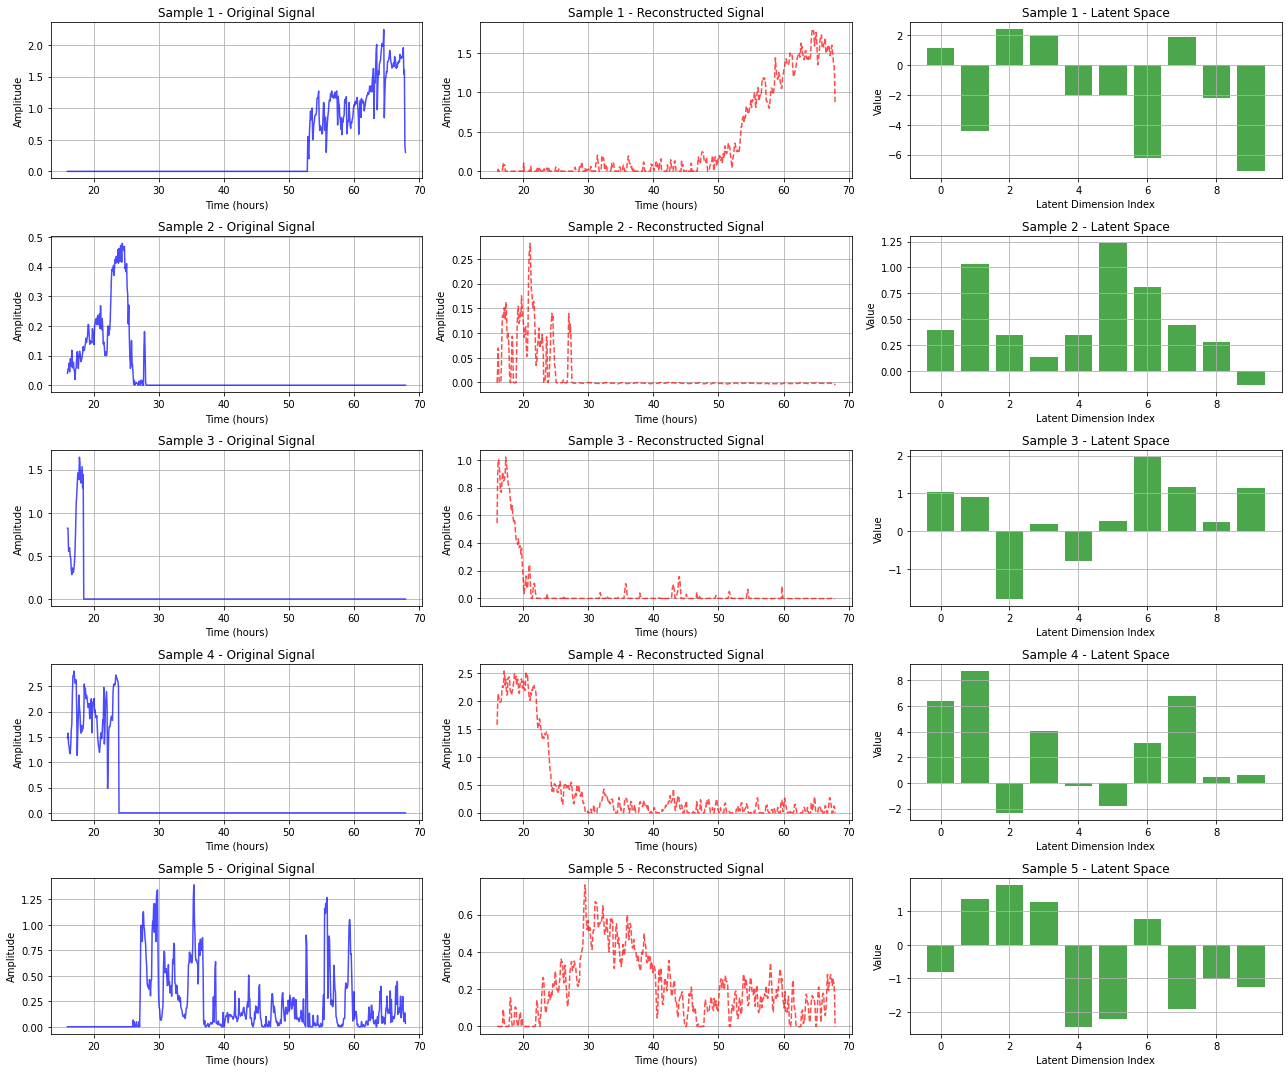

In [33]:
visualize_reconstruction(vae_model, eeg_dataset, num_samples=5)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        """
        A simple classifier network that takes the latent space from VAE encoder 
        and predicts class labels.
        """
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)
    
    
class VAEClassifier(nn.Module):
    def __init__(self, vae_encoder, classifier):
        """
        VAE Encoder + 分类器网络
        """
        super(VAEClassifier, self).__init__()
        self.encoder = vae_encoder  # 直接复用VAE的Encoder
        self.classifier = classifier  # 连接分类器

    def forward(self, x):
        mean, logvar = self.encoder(x)  # 提取latent特征
        z = self.reparameterize(mean, logvar)  # 采样latent space
        return self.classifier(z)  # 进行分类

    def reparameterize(self, mean, logvar):
        """
        VAE reparameterization trick
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

Epoch [1/50], Loss: 1.4951, Train Acc: 0.6560, Test Acc: 0.6970
Epoch [2/50], Loss: 1.3594, Train Acc: 0.6843, Test Acc: 0.7045
Epoch [3/50], Loss: 1.2731, Train Acc: 0.7164, Test Acc: 0.6894
Epoch [4/50], Loss: 1.1410, Train Acc: 0.7372, Test Acc: 0.6439
Epoch [5/50], Loss: 53.9249, Train Acc: 0.7618, Test Acc: 0.6439
Epoch [6/50], Loss: 1.2641, Train Acc: 0.6975, Test Acc: 0.6818
Epoch [7/50], Loss: 1.2190, Train Acc: 0.7221, Test Acc: 0.6970
Epoch [8/50], Loss: 1.0832, Train Acc: 0.7580, Test Acc: 0.6591
Epoch [9/50], Loss: 1.0330, Train Acc: 0.7675, Test Acc: 0.6515
Epoch [10/50], Loss: 0.9385, Train Acc: 0.7921, Test Acc: 0.6742
Epoch [11/50], Loss: 0.8495, Train Acc: 0.8185, Test Acc: 0.6970
Epoch [12/50], Loss: 0.7994, Train Acc: 0.8318, Test Acc: 0.6667
🔴 Early Stopping: Test accuracy hasn't improved for 10 epochs. Stopping training...


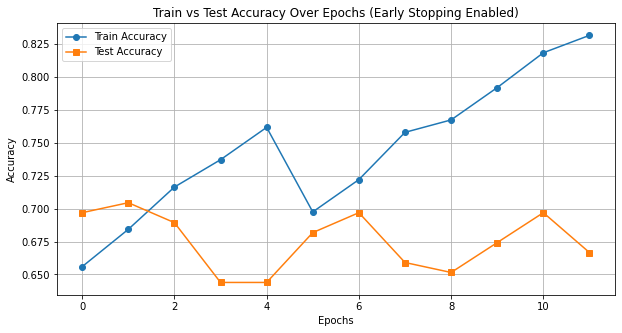

In [35]:
# 定义分类器
num_classes = 2  # 二分类
classifier = Classifier(latent_dim, num_classes).to(device)

# 组合 VAE Encoder 和 分类器
vae_classifier = VAEClassifier(vae_model.encoder, classifier).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vae_classifier.parameters(), lr=1e-3)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 存储训练损失 & 训练 / 测试准确率
train_losses = []
train_accuracies = []
test_accuracies = []

# Early Stopping 相关变量
patience = 10  # 当测试准确率连续 `patience` 轮没有提升，停止训练
best_test_acc = 0.0  # 记录最高的测试准确率
epochs_no_improve = 0  # 记录连续多少轮没有提升

num_epochs = 50
for epoch in range(num_epochs):
    vae_classifier.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # 训练阶段
    for data, labels in augmented_train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = vae_classifier(data)  # 通过VAE Encoder提取 latent space 并分类
        loss = criterion(outputs, labels)  # 计算分类损失
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        
        # 计算训练准确率
        predicted = torch.argmax(outputs, dim=1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train  # 训练集准确率
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # 评估测试集准确率
    vae_classifier.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, labels in augmented_test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = vae_classifier(data)
            predicted = torch.argmax(outputs, dim=1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test  # 测试集准确率
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    # **Early Stopping 机制**
    if test_accuracy > best_test_acc:
        best_test_acc = test_accuracy
        epochs_no_improve = 0  # 记录连续多少轮没有提升
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"🔴 Early Stopping: Test accuracy hasn't improved for {patience} epochs. Stopping training...")
        break

# **可视化训练 & 测试准确率**
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.plot(test_accuracies, label="Test Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Over Epochs (Early Stopping Enabled)")
plt.legend()
plt.grid()
plt.show()

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# **确保模型在评估模式**
vae_classifier.eval()

# **在整个测试集上进行预测**
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        outputs = vae_classifier(data)  # 通过VAE Encoder 提取 latent space 并分类
        predicted_labels = torch.argmax(outputs, dim=1)  # 获取预测类别
        
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# **计算最终测试集的 Accuracy**
final_test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"\n✅ Final Test Classification Accuracy: {final_test_accuracy:.4f}")

# **输出分类报告**
print("\n🔹 Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Bad Outcome", "Good Outcome"]))

# **计算并打印混淆矩阵**
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\n🔹 Confusion Matrix:")
print(conf_matrix)


✅ Final Test Classification Accuracy: 0.6481

🔹 Classification Report:
              precision    recall  f1-score   support

 Bad Outcome       0.94      0.63      0.75        46
Good Outcome       0.26      0.75      0.39         8

    accuracy                           0.65        54
   macro avg       0.60      0.69      0.57        54
weighted avg       0.84      0.65      0.70        54


🔹 Confusion Matrix:
[[29 17]
 [ 2  6]]


In [37]:
def extract_latent_features(vae_model, dataset):

    latent_features = []
    labels = []
    
    if hasattr(dataset, 'expanded_indices'):
        #print("🔹 Detected `AugmentedEEGDataset`, extracting features from expanded data...")
        dataset_type = "augmented"
    else:
        #print("🔹 Detected `EEGDataset` or `Subset`, extracting features normally...")
        dataset_type = "original"

    vae_model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            signal, label = dataset[i]
            # **检查是否有 `-1` 出现**
            if label not in [0, 1]:
                print(f"⚠️ Warning! Found label {label} at index {i}")

            if isinstance(signal, torch.Tensor):
                signal = signal.unsqueeze(0).to(device)  # 加入 batch 维度
            else:
                signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).to(device)  

            latent_vector = vae_model.get_embedding(signal).cpu().numpy()
            latent_features.append(latent_vector.flatten())
            labels.append(label)

    print(f"✅ Feature extraction complete! Extracted {len(latent_features)} samples.")
    return np.array(latent_features), np.array(labels)


In [38]:
# 检查数据集中是否有 -1 的标签
unique_labels = set()
for i in range(len(eeg_dataset)):  # 确保 `eeg_dataset` 是你的数据对象
    _, label = eeg_dataset[i]
    unique_labels.add(label)

print("🔍 Unique labels in `eeg_dataset`:", unique_labels)

latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

🔍 Unique labels in `eeg_dataset`: {0, 1}
✅ Feature extraction complete! Extracted 266 samples.


In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

# 🚀 1️⃣ 可视化 `latent feature` 作为 Heatmap
def visualize_latent_heatmap(latent_features, labels):
    """
    用 Heatmap 可视化 `latent feature`，适用于直接查看特征分布。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(latent_features, cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
    plt.title("Latent Feature Heatmap")
    plt.xlabel("Latent Dimensions")
    plt.ylabel("Samples")
    plt.colorbar(label="Feature Value")
    plt.show()

# 🚀 2️⃣ PCA 降维 + 2D/3D 可视化
def visualize_pca(latent_features, labels, dimensions=2):
    """
    用 PCA 降维 `latent feature` 并进行可视化。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    - dimensions: int, 降维目标维度 (2 或 3)
    """
    pca = PCA(n_components=dimensions)
    reduced_features = pca.fit_transform(latent_features)

    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    if dimensions == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        plt.legend(handles=handles, title="Labels")

        plt.title("PCA Projection of Latent Space (2D)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.grid(True)
        plt.show()

    elif dimensions == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)

        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        ax.legend(handles=handles, title="Labels")
        ax.set_title("PCA Projection of Latent Space (3D)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        plt.show()

# 🚀 3️⃣ t-SNE 代替 `UMAP`
def visualize_tsne(latent_features, labels, dimensions=2):
    """
    用 t-SNE 降维 `latent feature` 并进行可视化。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    - dimensions: int, 降维目标维度 (2)
    """
    tsne = TSNE(n_components=dimensions, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(latent_features)

    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
               Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
    plt.legend(handles=handles, title="Labels")

    plt.title("t-SNE Projection of Latent Space (2D)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

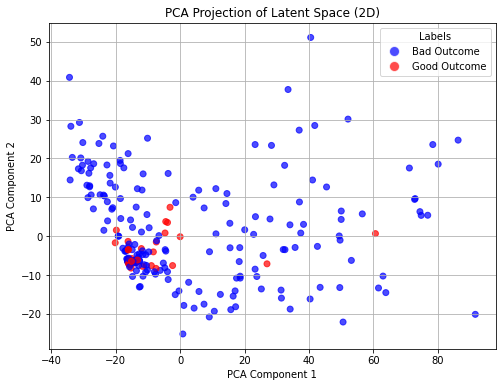

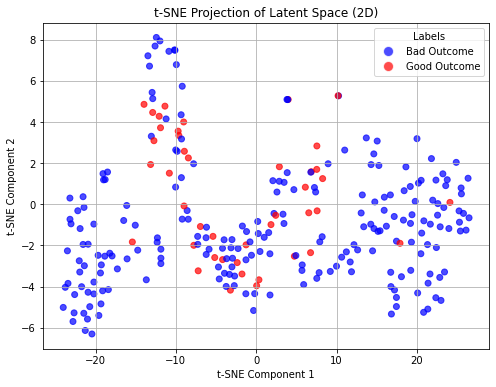

In [40]:
visualize_pca(latent_features, labels, dimensions=2)  # `PCA` 降到 `2D` 可视化
visualize_tsne(latent_features, labels, dimensions=2) # `t-SNE` 替代 `UMAP` 可视化

✅ Global Good Outcome Count: 43
✅ Global Bad Outcome Count: 223
✅ Global Good/Bad Ratio: 0.1928
✅ Best num_clusters (using Silhouette Score): 2

📊 Clustering Good/Bad Ratios:
✅ Cluster 1: Good Count = 41, Bad Count = 157, Good/Bad Ratio = 0.2611
✅ Cluster 2: Good Count = 2, Bad Count = 66, Good/Bad Ratio = 0.0303


/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


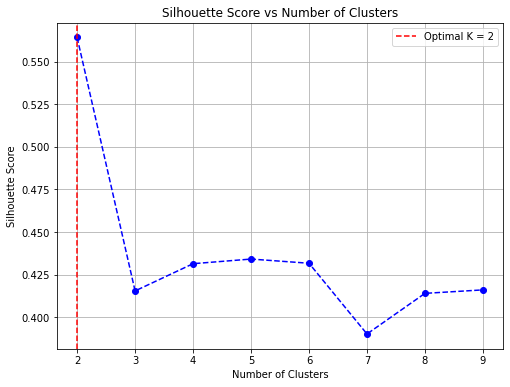

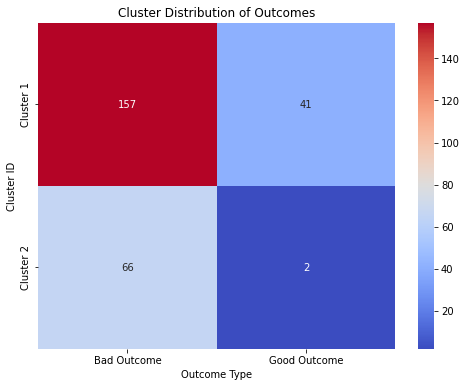

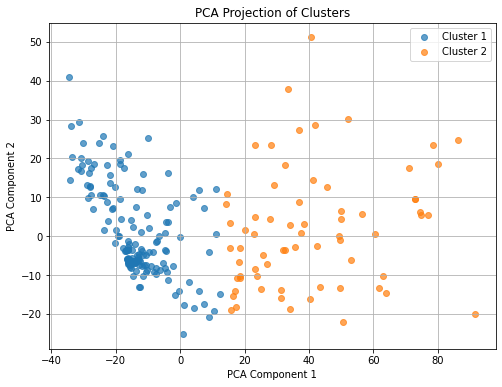


📊 Statistical Test Results:
Chi-Square Statistic: 10.5140
Chi-Square P-Value: 0.0012
Degrees of Freedom: 1
Expected Frequencies Table:
[[165.9924812  32.0075188]
 [ 57.0075188  10.9924812]]
✅ Chi-Square Test: The clustering significantly affects the Good/Bad distribution.

📊 T-Test Results:
T-Statistic: -0.4081
T-Test P-Value: 0.7228
❌ T-Test: No significant difference in Good/Bad Ratio among clusters.


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.decomposition import PCA

labels = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else labels
# 🚀 1️⃣ 计算全局 Good/Bad Ratio
total_good = np.sum(labels == 1)
total_bad = np.sum(labels == 0)
global_good_bad_ratio = total_good / total_bad if total_bad > 0 else np.inf

print(f"✅ Global Good Outcome Count: {total_good}")
print(f"✅ Global Bad Outcome Count: {total_bad}")
print(f"✅ Global Good/Bad Ratio: {global_good_bad_ratio:.4f}")

# 🚀 2️⃣ 选择最佳 num_clusters (使用 Silhouette Score)
silhouette_scores = []
possible_clusters = range(2, 10)  # 你可以调整最大聚类数

for k in possible_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(latent_features)
    score = silhouette_score(latent_features, cluster_labels)
    silhouette_scores.append(score)

# 🚀 3️⃣ 找到最佳 `num_clusters`
optimal_clusters = possible_clusters[np.argmax(silhouette_scores)]
print(f"✅ Best num_clusters (using Silhouette Score): {optimal_clusters}")

# 🚀 4️⃣ 重新训练最佳 K-Means 模型
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_features)

# 🚀 5️⃣ 统计不同类的 Good / Bad Outcome 和计算每个群组的 Good/Bad Ratio
contingency_table = np.zeros((optimal_clusters, 2))  # (Bad Outcome, Good Outcome)
group_good_bad_ratios = []

print("\n📊 Clustering Good/Bad Ratios:")
for i in range(optimal_clusters):
    n_bad = np.sum((cluster_labels == i) & (labels == 0))  # Bad Outcome 数量
    n_good = np.sum((cluster_labels == i) & (labels == 1))  # Good Outcome 数量
    contingency_table[i, 0] = n_bad
    contingency_table[i, 1] = n_good
    ratio = n_good / (n_bad + 1e-6)  # 避免除零错误
    group_good_bad_ratios.append(ratio)
    print(f"✅ Cluster {i+1}: Good Count = {n_good}, Bad Count = {n_bad}, Good/Bad Ratio = {ratio:.4f}")

# 🚀 6️⃣ 进行卡方检验 (Chi-Square Test)
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 🚀 7️⃣ 进行 T 检验 (判断群组的 Good/Bad Ratio 是否显著不同)
t_stat, t_p_value = ttest_ind(group_good_bad_ratios, np.full_like(group_good_bad_ratios, global_good_bad_ratio))

# 🚀 8️⃣ 画出 Silhouette Score 曲线
plt.figure(figsize=(8, 6))
plt.plot(possible_clusters, silhouette_scores, marker='o', linestyle='--', color='b')
plt.axvline(optimal_clusters, linestyle="--", color="r", label=f"Optimal K = {optimal_clusters}")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

# 🚀 9️⃣ 可视化不同类的 Outcome 分布 (热力图)
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt=".0f", xticklabels=["Bad Outcome", "Good Outcome"], yticklabels=[f"Cluster {i+1}" for i in range(optimal_clusters)])
plt.xlabel("Outcome Type")
plt.ylabel("Cluster ID")
plt.title("Cluster Distribution of Outcomes")
plt.show()

# 🚀 🔟 PCA 降维到 2D 进行可视化 (看看聚类效果)
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
for i in range(optimal_clusters):
    cluster_mask = cluster_labels == i
    plt.scatter(latent_pca[cluster_mask, 0], latent_pca[cluster_mask, 1], label=f"Cluster {i+1}", alpha=0.7)

plt.legend()
plt.title("PCA Projection of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# 🚀 🔟 输出统计检验结果
print("\n📊 Statistical Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"Chi-Square P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)
if p < 0.05:
    print("✅ Chi-Square Test: The clustering significantly affects the Good/Bad distribution.")
else:
    print("❌ Chi-Square Test: No significant effect of clustering on Good/Bad distribution.")

print("\n📊 T-Test Results:")
print(f"T-Statistic: {t_stat:.4f}")
print(f"T-Test P-Value: {t_p_value:.4f}")

if t_p_value < 0.05:
    print("✅ T-Test: The Good/Bad Ratio varies significantly across clusters.")
else:
    print("❌ T-Test: No significant difference in Good/Bad Ratio among clusters.")


🔍 原始数据最小值: 0.0
🔍 原始数据最大值: 3.4000000953674316
🔍 每个 Cluster 内数据最小值:
Cluster 1: Min 0.0, Max 3.0
Cluster 2: Min 0.0, Max 3.4000000953674316


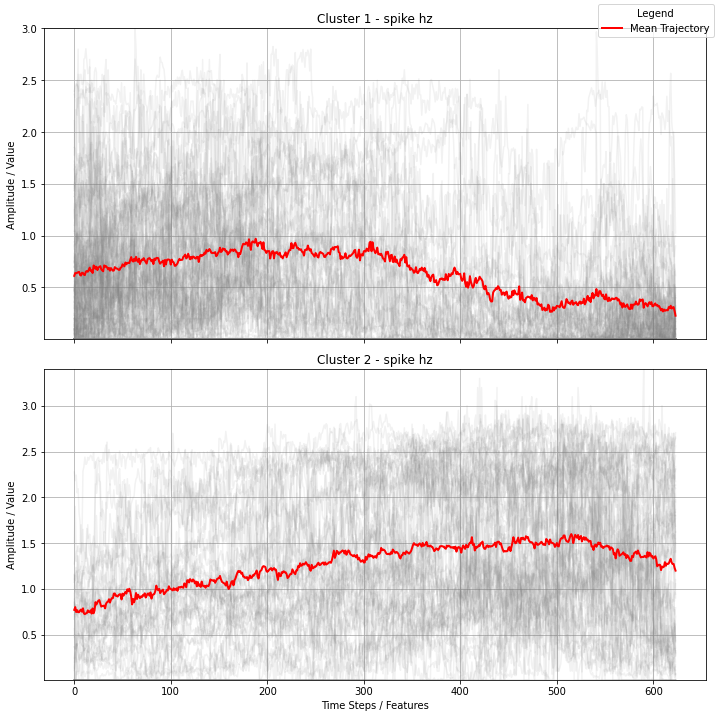

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 🚀 获取原始 EEG 数据
raw_data = np.array([eeg_dataset[i][0].numpy() for i in range(len(eeg_dataset))])  # (样本数, 通道数, 时间步)
num_channels=1
column_names=['spike hz']
print(f"🔍 原始数据最小值: {np.min(raw_data)}")
print(f"🔍 原始数据最大值: {np.max(raw_data)}")
print(f"🔍 每个 Cluster 内数据最小值:")
for i in range(optimal_clusters):
    cluster_mask = cluster_labels == i
    print(f"Cluster {i+1}: Min {np.min(raw_data[cluster_mask])}, Max {np.max(raw_data[cluster_mask])}")

# 🚀 画出不同 Cluster 的所有曲线（淡色背景）+ 平均值（突出显示）
fig, axes = plt.subplots(optimal_clusters, num_channels, figsize=(10, 5 * optimal_clusters), sharex=True)

if num_channels == 1:
    axes = np.expand_dims(axes, axis=1)  # 确保单通道情况下 axes 可迭代

for i in range(optimal_clusters):  # 遍历不同 Cluster
    cluster_mask = cluster_labels == i

    for ch in range(num_channels):  # 遍历不同 EEG 通道
        # 画出该 Cluster 内所有曲线（淡色背景）
        for sample in raw_data[cluster_mask, ch, :]:
            axes[i, ch].plot(sample, color="gray", alpha=0.1)  # 设置灰色背景，透明度低

        # 计算均值，忽略 0 值
        cluster_data = raw_data[cluster_mask, ch, :]
        cluster_data_no_zeros = np.where(cluster_data == 0, np.nan, cluster_data)  # 把 0 替换成 NaN
        cluster_data_mean = np.nanmean(cluster_data_no_zeros, axis=0)  # 计算均值，忽略 NaN

        # 画出该 Cluster 内的均值曲线（高亮）
        axes[i, ch].plot(cluster_data_mean, color="red", linewidth=2, label=f"Cluster {i+1} Mean")

        # 设置标题
        axes[i, ch].set_title(f"Cluster {i+1} - {column_names[ch]}")
        axes[i, ch].set_ylabel("Amplitude / Value")
        axes[i, ch].grid(True)
        
        # 设置每个子图的 y 轴范围为最合适的范围
        min_val = np.nanmin(cluster_data_no_zeros)
        max_val = np.nanmax(cluster_data_no_zeros)
        axes[i, ch].set_ylim(min_val, max_val)

# 统一 X 轴标签
axes[-1, 0].set_xlabel("Time Steps / Features")

# 添加图例
handles = [plt.Line2D([0], [0], color="red", linewidth=2, label="Mean Trajectory")]
fig.legend(handles=handles, loc="upper right", title="Legend")

plt.tight_layout()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from xgboost import XGBClassifier

# 提取训练集的潜在特征
X_train, y_train = extract_latent_features(vae_model, augmented_train_dataset)

# 提取测试集的潜在特征
X_test, y_test = extract_latent_features(vae_model, augmented_test_dataset)

# 确保 labels 是 numpy 数组
labels_train = np.array(y_train)
labels_test = np.array(y_test)

# 打印类别分布，检查数据是否平衡
print(f"Training set class distribution: {np.bincount(labels_train)}")
print(f"Testing set class distribution: {np.bincount(labels_test)}")

✅ Feature extraction complete! Extracted 529 samples.
✅ Feature extraction complete! Extracted 132 samples.
Training set class distribution: [354 175]
Testing set class distribution: [92 40]


In [21]:
# Create and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Compute AUC (for binary classification)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb[:, 1])  # Use probability of the positive class
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"XGB Accuracy: {accuracy_xgb:.4f}")
print(f"XGB AUC: {auc_xgb:.4f}")
print("\nXGB Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nXGB Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGB Accuracy: 0.7273
XGB AUC: 0.6019

XGB Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        92
           1       0.62      0.25      0.36        40

    accuracy                           0.73       132
   macro avg       0.68      0.59      0.59       132
weighted avg       0.71      0.73      0.68       132


XGB Confusion Matrix:
[[86  6]
 [30 10]]


In [22]:
# Create and train the SVM model
svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.decision_function(X_test)  # SVM requires decision_function

# Compute AUC
auc_svm = roc_auc_score(y_test, y_pred_proba_svm)  # Use decision function scores
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"\nSVM Accuracy: {accuracy_svm:.4f}")
print(f"SVM AUC: {auc_svm:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


SVM Accuracy: 0.5833
SVM AUC: 0.5897

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.57      0.65        92
           1       0.38      0.62      0.48        40

    accuracy                           0.58       132
   macro avg       0.58      0.60      0.57       132
weighted avg       0.66      0.58      0.60       132


SVM Confusion Matrix:
[[52 40]
 [15 25]]


In [23]:
latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

✅ Feature extraction complete! Extracted 266 samples.


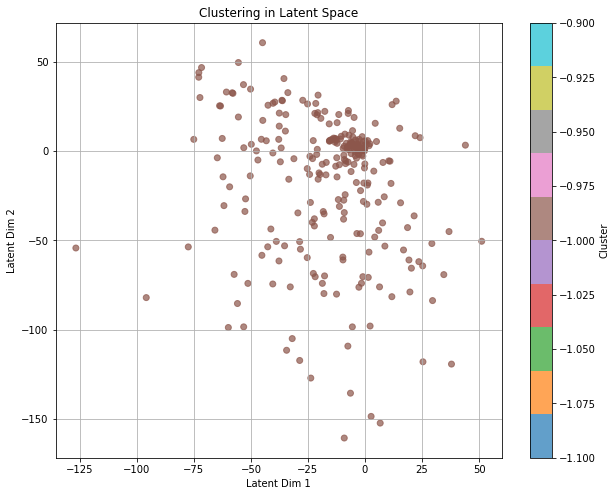


📊 Cluster Composition Analysis:
📌 Cluster -1:
   🔹 Good Outcome: 95 (35.7%)
   🔹 Bad Outcome: 171 (64.3%)
--------------------


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from collections import Counter

# **1️⃣ 直接用 KMeans / DBSCAN 聚类**
def cluster_latent_features(latent_features, method="kmeans"):
    if method == "kmeans":
        best_k = find_best_cluster_silhouette(latent_features)  # 自动找最佳 k
        model = KMeans(n_clusters=best_k, random_state=42)
    elif method == "dbscan":
        model = DBSCAN(eps=0.5, min_samples=5)  # DBSCAN 需要调整 `eps`
    else:
        raise ValueError("Only 'kmeans' or 'dbscan' is supported.")

    labels = model.fit_predict(latent_features)
    return labels

# **2️⃣ 计算 Silhouette Score 自动选择 `k`**
def find_best_cluster_silhouette(latent_features, max_clusters=10):
    best_k, best_score = 2, -1
    scores = []

    for k in range(2, max_clusters + 1):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(latent_features)
        score = silhouette_score(latent_features, labels)
        scores.append(score)
        if score > best_score:
            best_k, best_score = k, score

    print(f"✅ Best number of clusters (Silhouette Score): {best_k}")
    return best_k

# **3️⃣ 可视化 Latent Features**
def visualize_latent_features(latent_features, labels):
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_features[:, 0], latent_features[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(label="Cluster")
    plt.title("Clustering in Latent Space")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.grid(True)
    plt.show()

# **4️⃣ 统计每个 Cluster 里的 Good/Bad Outcome 组成**
def analyze_cluster_composition(labels, y_labels):
    cluster_counts = Counter(labels)
    cluster_stats = {}

    for cluster in cluster_counts.keys():
        indices = np.where(labels == cluster)[0]
        good_count = np.sum(y_labels[indices] == 1)
        bad_count = np.sum(y_labels[indices] == 0)
        total = good_count + bad_count

        cluster_stats[cluster] = {
            "Good Outcome": f"{good_count} ({good_count / total * 100:.1f}%)",
            "Bad Outcome": f"{bad_count} ({bad_count / total * 100:.1f}%)"
        }

    print("\n📊 Cluster Composition Analysis:")
    for cluster, stats in cluster_stats.items():
        print(f"📌 Cluster {cluster}:")
        print(f"   🔹 Good Outcome: {stats['Good Outcome']}")
        print(f"   🔹 Bad Outcome: {stats['Bad Outcome']}")
        print("-" * 20)

# **🔥 运行流程**
latent_features = np.array(latent_features)  # 确保是 NumPy 数组
labels = cluster_latent_features(latent_features, method="dbscan")  # KMeans
visualize_latent_features(latent_features, labels)  # 可视化
analyze_cluster_composition(labels, np.array(y_train))  # 统计 Good/Bad 成分

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(latent_features, labels, method='pca', dimensions=2):
    """
    降维并可视化潜在特征，支持2D和3D。

    参数：
    - latent_features: (样本数, 特征维度) 的 NumPy 数组
    - labels: 1D NumPy 数组，样本标签
    - method: 'pca' 或 'tsne'
    - dimensions: 2 或 3，决定可视化的维度
    """
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be 2 or 3.")

    # **检查并过滤无效标签**
    valid_indices = labels >= 0  # 过滤掉 -1 的数据
    latent_features = latent_features[valid_indices]
    labels = labels[valid_indices]

    # 降维
    if method == 'pca':
        reducer = PCA(n_components=dimensions)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"PCA of Latent Features ({dimensions}D)"
    elif method == 'tsne':
        reducer = TSNE(n_components=dimensions, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"t-SNE of Latent Features ({dimensions}D)"
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 颜色映射
    color_map = {-1: 'gray', 0: 'blue', 1: 'red'}  # -1 变为灰色
    colors = [color_map[label] for label in labels]

    # 可视化
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

    # 创建自定义图例
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Bad Outcome'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Good Outcome'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Unknown (-1)')
    ]
    plt.legend(handles=handles, title="Labels")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# **调用可视化函数**
visualize_latent_space(latent_features, labels, method='pca', dimensions=2)

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required by PCA.

/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/var/folders/8b/cc9112l96mv2srtjrnzbht8w0000gn/T/ipykernel_16860/137273506.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3

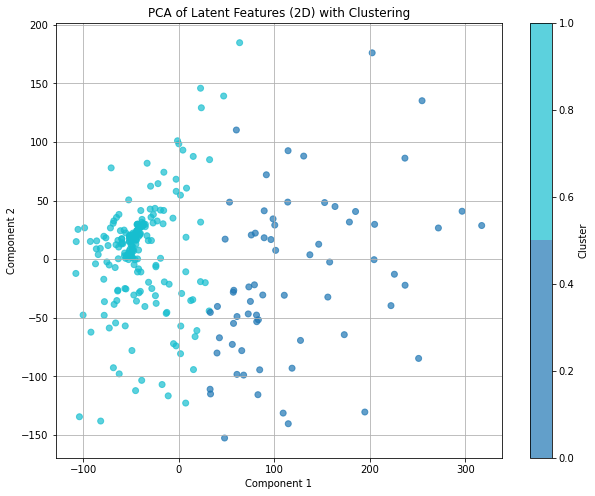

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

def visualize_latent_space_with_clustering(latent_features, method='pca', dimensions=2, n_clusters=2):
    """
    先进行KMeans聚类，再降维并可视化（支持PCA或t-SNE），支持2D和3D可视化。

    参数：
    - latent_features: 2D numpy array，形状为 (样本数, 特征维度)
    - method: str, 降维方法 ('pca' 或 'tsne')
    - dimensions: int, 降维到2维或3维 (2或3)
    - n_clusters: int, KMeans 聚类数目
    """
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be 2 or 3.")

    # 先进行 KMeans 聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_features)

    # 再降维
    if method == 'pca':
        reducer = PCA(n_components=dimensions)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"PCA of Latent Features ({dimensions}D) with Clustering"
    elif method == 'tsne':
        reducer = TSNE(n_components=dimensions, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"t-SNE of Latent Features ({dimensions}D) with Clustering"
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 可视化
    colors = plt.cm.get_cmap('tab10', n_clusters)  # 颜色映射
    if dimensions == 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap=colors, alpha=0.7)
        plt.colorbar(label="Cluster")
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

    elif dimensions == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], 
                             c=cluster_labels, cmap=colors, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        plt.colorbar(scatter, label="Cluster")
        plt.show()

# 示例调用
# 假设 latent_features 是你的特征数据
visualize_latent_space_with_clustering(latent_features, method='pca', dimensions=2, n_clusters=2)

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 拆分训练和测试集
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.2, random_state=42)

# 训练 XGBoost 分类器
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost 分类准确率: {accuracy:.4f}")


import shap

# 计算 SHAP 重要性
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 可视化重要特征
shap.summary_plot(shap_values, X_test)




ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [-1]

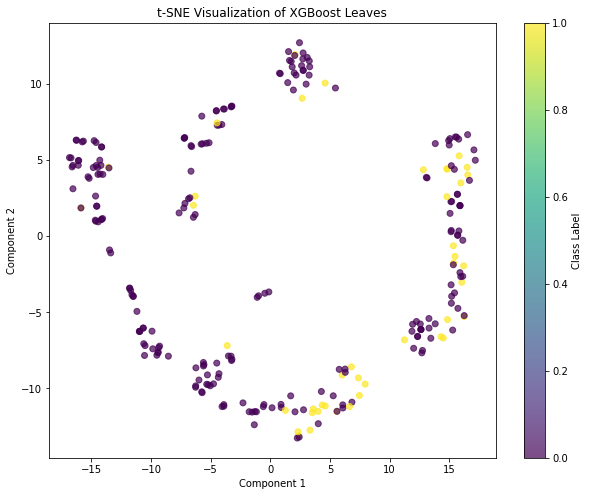

In [46]:
# 提取 XGBoost 叶子节点作为特征
X_leaves = model.apply(latent_features)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_leaves)

# 可视化
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Class Label")
plt.title("t-SNE Visualization of XGBoost Leaves")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 列出所有分类器
classifiers = {
    'SVM': SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# 使用分层划分进行训练和测试集划分
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

# 循环遍历每个分类器进行训练和评估
for name, classifier in classifiers.items():
    # 创建并训练分类器
    classifier.fit(X_train, y_train)

    # 预测并评估模型
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 打印分类结果
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("=" * 50)  # 分隔线

Classifier: SVM
Accuracy: 0.6125

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        51
           1       0.47      0.48      0.47        29

    accuracy                           0.61        80
   macro avg       0.58      0.58      0.58        80
weighted avg       0.62      0.61      0.61        80


Confusion Matrix:
[[35 16]
 [15 14]]
Classifier: Random Forest
Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.90      0.75        51
           1       0.44      0.14      0.21        29

    accuracy                           0.62        80
   macro avg       0.55      0.52      0.48        80
weighted avg       0.57      0.62      0.56        80


Confusion Matrix:
[[46  5]
 [25  4]]
Classifier: Logistic Regression
Accuracy: 0.6750

Classification Report:
              precision    recall  f1-score   support

           0      

/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: KNN
Accuracy: 0.6875

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79        51
           1       0.70      0.24      0.36        29

    accuracy                           0.69        80
   macro avg       0.69      0.59      0.58        80
weighted avg       0.69      0.69      0.64        80


Confusion Matrix:
[[48  3]
 [22  7]]


/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



=== Experiment with Padding Mode: constant ===
Epoch 1/100, Train Loss: 1.1426, Test Loss: 0.9466
Epoch 2/100, Train Loss: 0.9198, Test Loss: 0.7692
Epoch 3/100, Train Loss: 0.5170, Test Loss: 0.4085
Epoch 4/100, Train Loss: 0.3940, Test Loss: 0.3714
Epoch 5/100, Train Loss: 0.3895, Test Loss: 0.3670
Epoch 6/100, Train Loss: 0.3622, Test Loss: 0.3556
Epoch 7/100, Train Loss: 0.3471, Test Loss: 0.3465
Epoch 8/100, Train Loss: 0.3421, Test Loss: 0.3412
Epoch 9/100, Train Loss: 0.3399, Test Loss: 0.3402
Epoch 10/100, Train Loss: 0.3381, Test Loss: 0.3385
Epoch 11/100, Train Loss: 0.3365, Test Loss: 0.3369
Epoch 12/100, Train Loss: 0.3344, Test Loss: 0.3349
Epoch 13/100, Train Loss: 0.3314, Test Loss: 0.3308
Epoch 14/100, Train Loss: 0.3256, Test Loss: 0.3222
Epoch 15/100, Train Loss: 0.3131, Test Loss: 0.3053
Epoch 16/100, Train Loss: 0.2989, Test Loss: 0.2881
Epoch 17/100, Train Loss: 0.2816, Test Loss: 0.2619
Epoch 18/100, Train Loss: 0.2543, Test Loss: 0.2579
Epoch 19/100, Train Loss:

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.



=== Results for Padding Mode: constant ===
Accuracy: 0.7833

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.20      0.10      0.13        10

    accuracy                           0.78        60
   macro avg       0.52      0.51      0.50        60
weighted avg       0.73      0.78      0.75        60


Confusion Matrix:
[[46  4]
 [ 9  1]]

=== Experiment with Padding Mode: reflect ===
Epoch 1/100, Train Loss: 0.2760, Test Loss: 0.0898
Epoch 2/100, Train Loss: 0.1316, Test Loss: 0.0777
Epoch 3/100, Train Loss: 0.1222, Test Loss: 0.0758
Epoch 4/100, Train Loss: 0.1193, Test Loss: 0.0748
Epoch 5/100, Train Loss: 0.1178, Test Loss: 0.0741
Epoch 6/100, Train Loss: 0.1168, Test Loss: 0.0733
Epoch 7/100, Train Loss: 0.1147, Test Loss: 0.0745
Epoch 8/100, Train Loss: 0.1128, Test Loss: 0.0715
Epoch 9/100, Train Loss: 0.1091, Test Loss: 0.0804
Epoch 10/100, Train Loss: 0.1121, Test Loss:

Epoch 10/100, Train Loss: 0.1419, Test Loss: 0.1672
Epoch 11/100, Train Loss: 0.1398, Test Loss: 0.1654
Epoch 12/100, Train Loss: 0.1387, Test Loss: 0.1663
Epoch 13/100, Train Loss: 0.1374, Test Loss: 0.1616
Epoch 14/100, Train Loss: 0.1346, Test Loss: 0.1657
Epoch 15/100, Train Loss: 0.1364, Test Loss: 0.1768
Epoch 16/100, Train Loss: 0.1408, Test Loss: 0.1733
Epoch 17/100, Train Loss: 0.1361, Test Loss: 0.1567
Epoch 18/100, Train Loss: 0.1301, Test Loss: 0.1548
Epoch 19/100, Train Loss: 0.1280, Test Loss: 0.1545
Epoch 20/100, Train Loss: 0.1276, Test Loss: 0.1523
Epoch 21/100, Train Loss: 0.1264, Test Loss: 0.1513
Epoch 22/100, Train Loss: 0.1261, Test Loss: 0.1533
Epoch 23/100, Train Loss: 0.1266, Test Loss: 0.1537
Epoch 24/100, Train Loss: 0.1252, Test Loss: 0.1514
Epoch 25/100, Train Loss: 0.1241, Test Loss: 0.1502
Epoch 26/100, Train Loss: 0.1249, Test Loss: 0.1486
Epoch 27/100, Train Loss: 0.1227, Test Loss: 0.1488
Epoch 28/100, Train Loss: 0.1226, Test Loss: 0.1504
Epoch 29/100

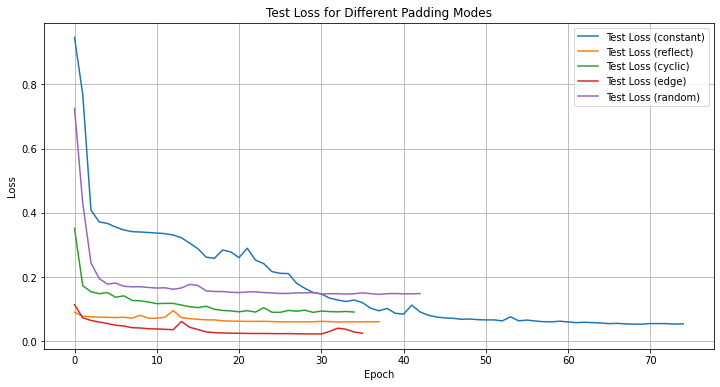


Final Classification Accuracy for Each Padding Mode:
Constant Padding: Accuracy = 0.7833
Reflect Padding: Accuracy = 0.8000
Cyclic Padding: Accuracy = 0.7833
Edge Padding: Accuracy = 0.8333
Random Padding: Accuracy = 0.7833


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 定义不同的填充策略
padding_modes = ["constant", "reflect", "cyclic", "edge", "random"]

# 存储每种策略的实验结果
results = {mode: {"train_losses": [], "test_losses": [], "accuracy": None, "classification_report": None, "confusion_matrix": None} for mode in padding_modes}

# 超参数设置
latent_dim = 7
seq_length = 1139
batch_size = 32
epochs = 100
alpha = 1e-6
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据文件路径
data_folder = '5min_smoothed_data/'
outcome_file = 'valid_patients_outcome.csv'

for mode in padding_modes:
    print(f"\n=== Experiment with Padding Mode: {mode} ===")
    
    # Step 1: 数据加载与处理
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=False)
    train_size = int(0.8 * len(eeg_dataset))
    test_size = len(eeg_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Step 2: 定义模型并训练
    vae_model = VAE(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
        test_loss = test(vae_model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # 早停机制
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break
    
    results[mode]["train_losses"] = train_losses
    results[mode]["test_losses"] = test_losses

    # Step 3: 提取潜在特征和标签
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=True)
    latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

    # Step 4: 划分训练集和测试集（分类任务）
    X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.2, random_state=42, stratify=labels)

    # Step 5: 训练 XGBoost 分类器
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)

    # Step 6: 测试并评估分类器
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[mode]["accuracy"] = accuracy
    results[mode]["classification_report"] = class_report
    results[mode]["confusion_matrix"] = conf_matrix

    print(f"\n=== Results for Padding Mode: {mode} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

# 绘制各填充模式的测试损失曲线
plt.figure(figsize=(12, 6))
for mode in padding_modes:
    plt.plot(results[mode]["test_losses"], label=f'Test Loss ({mode})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss for Different Padding Modes')
plt.legend()
plt.grid(True)
plt.show()

# 打印所有填充模式的最终分类精度
print("\nFinal Classification Accuracy for Each Padding Mode:")
for mode in padding_modes:
    print(f"{mode.capitalize()} Padding: Accuracy = {results[mode]['accuracy']:.4f}")